In [1]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


In [3]:
%cd usad

/home/seonggye/TSAD/usad/usad


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [5]:

!nvidia-smi -L

device = get_default_device()

GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-068e030c-2069-ee5c-2a9c-7f04402c4421)


In [6]:
device

device(type='cuda')

### Normal period
Train data

In [14]:
normal = pd.read_csv("/home/seonggye/TSAD/PSM/train.csv")

In [15]:
normal = normal.drop(["timestamp_(min)" ] , axis = 1)
normal.shape

(132481, 25)

In [25]:
# Dataframe value 자료형이 모두 float64 이므로 자료형 변경 불필요
normal.dtypes

feature_0     float64
feature_1     float64
feature_2     float64
feature_3     float64
feature_4     float64
feature_5     float64
feature_6     float64
feature_7     float64
feature_8     float64
feature_9     float64
feature_10    float64
feature_11    float64
feature_12    float64
feature_13    float64
feature_14    float64
feature_15    float64
feature_16    float64
feature_17    float64
feature_18    float64
feature_19    float64
feature_20    float64
feature_21    float64
feature_22    float64
feature_23    float64
feature_24    float64
dtype: object

In [28]:
# 결측치 확인 -> 결측치가 전체 데이터셋 크기의 3% 정도이므로 drop 후 진행 
# (시계열에서 결측치 처리 어떻게 하나요? 그냥 보간법 쓰는건가?)
print(normal.isnull().sum())


feature_0        0
feature_1        0
feature_2        0
feature_3        0
feature_4      202
feature_5      249
feature_6      563
feature_7       47
feature_8       47
feature_9        0
feature_10      47
feature_11       0
feature_12       0
feature_13     249
feature_14     202
feature_15       0
feature_16       0
feature_17       0
feature_18     202
feature_19       0
feature_20       0
feature_21    2136
feature_22     204
feature_23       0
feature_24      47
dtype: int64


In [29]:
# 결측치 제거
normal = normal.dropna()

In [31]:
print(normal.isnull().sum())

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
dtype: int64


### Normalize 진행

In [32]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

### Attack
Test data

In [36]:
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
# attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
# attack.shape

/home/seonggye/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [59]:
attack = pd.read_csv("/home/seonggye/TSAD/PSM/test.csv")
labels_df = pd.read_csv("/home/seonggye/TSAD/PSM/test_label.csv")
attack = attack.drop(["timestamp_(min)"] , axis = 1)

In [60]:
labels_df

,timestamp_(min),label
0,132480.0,0
1,132481.0,0
2,132482.0,0
3,132483.0,0
4,132484.0,0
5,132485.0,0
6,132486.0,0
7,132487.0,0
8,132488.0,0
9,132489.0,0


In [66]:
labels = [float(labels_df["label"][i]) for i in range(len(labels_df))]

### Normalize attack

In [68]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [69]:
attack.head(2)


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.562567,0.997994,0.320164,0.943156,0.445269,0.412541,0.326087,0.400763,0.491746,0.499890,...,0.314090,0.458432,0.280697,0.300064,0.273950,0.020236,0.157895,0.062437,0.008715,0.097674
1,0.562663,0.997882,0.322051,0.943261,0.489054,0.433168,0.369565,0.416455,0.513990,0.518492,...,0.309838,0.482016,0.277158,0.320698,0.271754,0.018550,0.157895,0.083363,0.010893,0.102326


### Windows

In [70]:
window_size=12


In [71]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(129772, 12, 25)

In [72]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(87829, 12, 25)

### Training

In [73]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [74]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0285, val_loss2: 0.0295
Epoch [1], val_loss1: 0.0240, val_loss2: 0.0019
Epoch [2], val_loss1: 0.0187, val_loss2: -0.0058
Epoch [3], val_loss1: 0.0188, val_loss2: -0.0087
Epoch [4], val_loss1: 0.0199, val_loss2: -0.0111
Epoch [5], val_loss1: 0.0206, val_loss2: -0.0140
Epoch [6], val_loss1: 0.0266, val_loss2: -0.0192
Epoch [7], val_loss1: 0.0274, val_loss2: -0.0201
Epoch [8], val_loss1: 0.0247, val_loss2: -0.0194
Epoch [9], val_loss1: 0.0229, val_loss2: -0.0185
Epoch [10], val_loss1: 0.0225, val_loss2: -0.0185
Epoch [11], val_loss1: 0.0227, val_loss2: -0.0190
Epoch [12], val_loss1: 0.0225, val_loss2: -0.0191
Epoch [13], val_loss1: 0.0225, val_loss2: -0.0194
Epoch [14], val_loss1: 0.0225, val_loss2: -0.0196
Epoch [15], val_loss1: 0.0225, val_loss2: -0.0198
Epoch [16], val_loss1: 0.0225, val_loss2: -0.0199
Epoch [17], val_loss1: 0.0225, val_loss2: -0.0201
Epoch [18], val_loss1: 0.0224, val_loss2: -0.0201
Epoch [19], val_loss1: 0.0222, val_loss2: -0.0199
Epoch [20], 

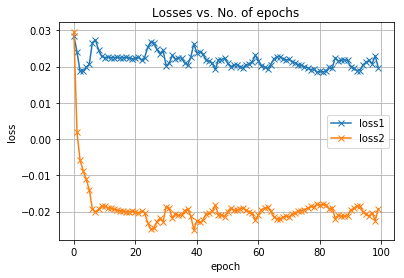

In [75]:
plot_history(history)

In [76]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

### Test

In [77]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [78]:
results=testing(model,test_loader)


In [79]:

windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [80]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]


In [81]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

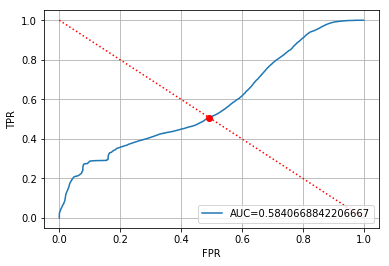

In [82]:
threshold=ROC(y_test,y_pred)
